In [ ]:
#default_exp vision.core
#default_cls_lvl 3

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.core import *
from local.data.external import *

from PIL import Image

In [ ]:
#export
_all_ = ['Image']

In [ ]:
#hide
torch.cuda.set_device(int(os.environ.get('DEFAULT_GPU') or 0))

# Core vision
> Basic image opening/processing functionality

## Basic types

In [ ]:
path = untar_data(URLs.MNIST_TINY)
fns = get_image_files(path)
fn = fns[0]; fn

PosixPath('/home/sgugger/git/fastai_docs/dev/data/mnist_tiny/train/3/8055.png')

In [ ]:
#export
class PILImage():
    kwargs = dict(cmap='viridis')
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_image(o, ctx=ctx, **{**PILImage.kwargs, **kwargs})

In [ ]:
#export
class Imagify(Transform):
    "Open an `Image` from path `fn`"
    def __init__(self, func=Image.open):  self.func = func
    def encodes(self, fn)->PILImage: return self.func(fn)

In [ ]:
timg = Imagify()
img = timg(fn)
test_eq(img.size, (28,28))
img

In [ ]:
#export
class Mask(PILImage):
    kwargs = dict(cmap='tab20', alpha=0.5)
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_image(o, ctx=ctx, **{**Mask.kwargs, **kwargs})

In [ ]:
#export
class Maskify(Transform):
    "Open an `Image` from path `fn`"
    def __init__(self, func=Image.open): self.func = func
    def encodes(self, fn)->Mask: return self.func(fn)

In [ ]:
tmask = Maskify(func=lambda fn: Image.fromarray((array(Image.open(fn)) >= 127).astype(np.uint8)))
mask = tmask(fn)
test_eq(mask.size, (28,28))

In [ ]:
# export
class TensorPoint():
    kwargs = dict(s=10, marker='.', c='r')
    @staticmethod
    def show(o, ctx=None, **kwargs): 
        if 'figsize' in kwargs: del kwargs['figsize']
        ctx.scatter(o[:, 1], o[:, 0], **{**TensorPoint.kwargs, **kwargs})
        return ctx

In [ ]:
# export
class Pointify(Transform):
    def encodes(self, t)->TensorPoint: return tensor(t).view(-1, 2).float()

In [ ]:
pnts = np.array([[0,0], [14,0], [28,0], [0,28], [14,28], [28,28]])
tpnts = Pointify()(pnts)
test_eq(tpnts.shape, [6,2])
test_eq(tpnts.dtype, torch.float32)

In [ ]:
# export
from fastai.vision.data import get_annotations
from matplotlib import patches, patheffects

def _draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

def _draw_rect(ax, b, color='white', text=None, text_size=14, hw=True, rev=False):
    lx,ly,w,h = b
    if rev: lx,ly,w,h = ly,lx,h,w
    if not hw: w,h = w-lx,h-ly
    patch = ax.add_patch(patches.Rectangle((lx,ly), w, h, fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(lx,ly, text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [ ]:
# export
class TensorBBox(TensorPoint):
    @staticmethod
    def show(x, ctx=None, **kwargs):
        bbox,label = x
        for b,l in zip(bbox, label): 
            if l != '#bg': _draw_rect(ctx, b, hw=False, rev=True, text=l)
        return ctx

In [ ]:
# export
class BBoxify(Transform):
    def encodes(self, x)->TensorBBox: return (tensor(x[0]).view(-1, 4).float(),x[1])

In [ ]:
bboxes = (np.array([[0,0,7,7], [10,14,27, 27]]), ['tl', 'br'])
tbbs = BBoxify()(bboxes)

## Functions

In [ ]:
#export
class ImageConverter(Transform):
    "Convert `img` to `mode`"
    def __init__(self, mode='RGB', mask_mode='L'): self.modes = (mode,mask_mode)
    def encodes(self, o:PILImage): return o.convert(self.modes[0])
    def encodes(self, o:Mask):     return o.convert(self.modes[1])

In [ ]:
f = ImageConverter('RGB')
f.accept_types(PILImage)
test_eq(f(img).mode, 'RGB')
f.accept_types(Mask)
test_eq(f(mask).mode, 'L')

In [ ]:
#export
def image_resize(img, size, resample=Image.BILINEAR):
    "Resize image to `size` using `resample"
    return img.resize(size, resample=resample)
image_resize.order=10

In [ ]:
#export
class ImageResizer(Transform):
    "Resize image to `size` using `resample"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = size,resample

    def encodes(self, o:PILImage): return image_resize(o, size=self.size, resample=self.resample)

In [ ]:
f = ImageResizer(14)
f.accept_types(PILImage)
test_eq(f(img).size, (14,14))
f.accept_types(Mask)
test_eq(f(mask).size, (14,14))

In [ ]:
# export
def image2byte(img):
    "Transform image to byte tensor in `c*h*w` dim order."
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
    w,h = img.size
    return res.view(h,w,-1).permute(2,0,1)

In [ ]:
#export
class ImageToByteTensor(Transform):
    "Transform image to byte tensor in `c*h*w` dim order."
    order = 15
    def encodes(self, o:PILImage)->TensorImage: return image2byte(o)
    def encodes(self, o:Mask)    ->TensorMask:  return image2byte(o)[0]

In [ ]:
tfm = ImageToByteTensor()
tfm.accept_types(PILImage)
test_eq(tfm(img).shape, (1,28,28))
test_eq(tfm.return_type(), TensorImage)
tfm.accept_types(Mask)
test_eq(tfm(mask).shape, (28,28))
test_eq(tfm.return_type(), TensorMask)

Let's confirm we can pipeline this with `Imagify`.

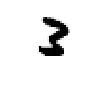

In [ ]:
pipe_img = Pipeline([Imagify(), ImageToByteTensor()])
img = pipe_img(fn)
test_eq(img.shape, (1,28,28))
PILImage.kwargs['cmap'] = 'Greys'
pipe_img.show(img, figsize=(1,1));

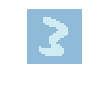

In [ ]:
pipe_mask = Pipeline([tmask, ImageToByteTensor()])
mask = pipe_mask(fn)
test_eq(mask.shape, (28,28))
pipe_mask.show(mask, figsize=(1,1));

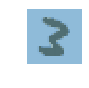

In [ ]:
ax = pipe_img.show(img, figsize=(1,1));
pipe_mask.show(mask, ctx=ax);

In [ ]:
# export
class PointScaler(Transform):
    def __init__(self, do_scale=True, y_first=False): self.do_scale,self.y_first = do_scale,y_first
    
    def encodes(self, x, y:TensorPoint):
        sz = x.shape[-2:] if isinstance(x, Tensor) else [x.size[1],x.size[0]]
        if self.do_scale: y = y * 2/tensor(sz).float() - 1
        if not self.y_first: y = y.flip(1)
        return (x,y)
    
    def decodes(self, x, y:TensorPoint):
        y = y.flip(1)
        sz = x.shape[-2:] if isinstance(x, Tensor) else [x.size[1],x.size[0]]
        y = (y+1) * tensor([x.shape[-2:]]).float()/2
        return (x,y)

In [ ]:
def _lbl(x): return pnts
tds = TfmdDS([fn], [[Imagify(), ImageToByteTensor()], [_lbl,Pointify()]], tuple_tfms=PointScaler())

In [ ]:
x,y = tds[0]
#Scaling and flipping properly done
test_eq(y, tensor([[-1., -1.], [-1.,  0.], [-1.,  1.], [ 1., -1.], [ 1.,  0.], [ 1.,  1.]]))
a,b = tds.decode((x,y))
test_eq(b, tensor(pnts).float())

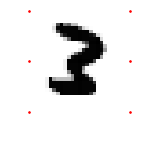

In [ ]:
tds.show_at(0, figsize=(2,2));

In [ ]:
def _lbl(x): return pnts
tds = TfmdDS([fn], [[Imagify()], [_lbl,Pointify()]], tuple_tfms=[PointScaler(), ImageToByteTensor()])

In [ ]:
x,y = tds[0]
#Scaling and flipping properly done
test_eq(y, tensor([[-1., -1.], [-1.,  0.], [-1.,  1.], [ 1., -1.], [ 1.,  0.], [ 1.,  1.]]))
a,b = tds.decode((x,y))
test_eq(b, tensor(pnts).float())

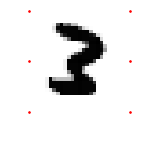

In [ ]:
tds.show_at(0, figsize=(2,2));

In [ ]:
# export
class BBoxScaler(Transform):
    def __init__(self): 
        self.scale = PointScaler()
        self.scale.accept_types([TensorImage, TensorPoint])
        
    def encodes(self, x, y:TensorBBox): 
        return (x,(self.scale((x,y[0].view(-1,2)))[1].view(-1,4),y[1]))
    
    def decodes(self, x, y:TensorBBox):    
        _,bbox = self.scale.decode((x,y[0].view(-1,2)))
        return (x, (bbox.view(-1,4), y[1]))

In [ ]:
#Fails
#class BBoxScaler(PointScaler):
#    def encodes(self, x:TensorImage, y:TensorBBox): 
#        return (x,(super().__call__((x,y[0].view(-1,2)))[1].view(-1,4),y[1]))
#    
#    def decodes(self, x:TensorImage, y:TensorBBox):    
#        _,bbox = super().decode((x,y[0].view(-1,2)))
#        return (x, (bbox.view(-1,4), y[1]))

In [ ]:
# export
class BBoxCategorize(Transform):
    "Reversible transform of category string to `vocab` id"
    order,state_args=1,'vocab'
    def __init__(self, vocab=None, subset_idx=None):
        self.vocab,self.subset_idx = vocab,subset_idx
        self.o2i = None if vocab is None else {v:k for k,v in enumerate(vocab)}
        
    def setup(self, dsrc):
        if not dsrc: return
        dsrc = dsrc.train if self.subset_idx is None else dsrc.subset(self.subset_idx)
        vals = set()
        for b,c in dsrc: vals = vals.union(set(c))
        self.vocab,self.otoi = uniqueify(list(vals), sort=True, bidir=True, start='#bg')

    def encodes(self, o): return (o[0],tensor([self.otoi[o_] for o_ in o[1] if o_ in self.otoi]))
    def decodes(self, i): return (i[0],[self.vocab[i_] for i_ in i[1]])

In [ ]:
def _lbl1(x): return bboxes
tcat = BBoxCategorize(subset_idx=[0])
tds = TfmdDS([fn], [[Imagify(), ImageToByteTensor()], [_lbl1,BBoxify(), tcat]], tuple_tfms=BBoxScaler())

In [ ]:
x,y = tds[0]

In [ ]:
y

(tensor([[-1.0000, -1.0000, -0.5000, -0.5000],
         [ 0.0000, -0.2857,  0.9286,  0.9286]]), (#2) [2,1])

In [ ]:
x,y = tds[0]
#Scaling and flipping properly done
test_close(y[0], tensor([[-1, -1, -0.5, -0.5],[0, -1+10/14, -1+27/14, -1+27/14]]))
test_eq(y[1], [2,1])
a,b = tds.decode((x,y))
test_close(b[0], tensor(bboxes[0]).float())
test_eq(b[1], bboxes[1])

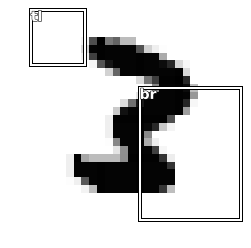

In [ ]:
tds.show_at(0)

In [ ]:
tds = TfmdDS([fn], [[Imagify()], [_lbl1,BBoxify(), tcat]], tuple_tfms=[BBoxScaler(), ImageToByteTensor()])

In [ ]:
x,y = tds[0]
#Scaling and flipping properly done
test_close(y[0], tensor([[-1, -1, -0.5, -0.5],[0, -1+10/14, -1+27/14, -1+27/14]]))
test_eq(y[1], [2,1])
a,b = tds.decode((x,y))
test_close(b[0], tensor(bboxes[0]).float())
test_eq(b[1], bboxes[1])

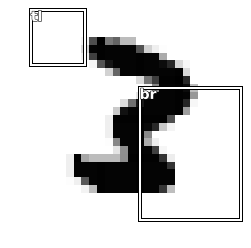

In [ ]:
tds.show_at(0)

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 02_data_pipeline.ipynb.
Converted 03_data_external.ipynb.
Converted 04_data_core.ipynb.
Converted 05_data_source.ipynb.
Converted 06_vision_core.ipynb.
Converted 07_pets_tutorial-meta.ipynb.
Converted 07_pets_tutorial.ipynb.
Converted 08_vision_augment.ipynb.
Converted 10_layers.ipynb.
Converted 11_optimizer.ipynb.
Converted 12_learner.ipynb.
Converted 13_callback_schedule.ipynb.
Converted 14_callback_hook.ipynb.
Converted 15_callback_progress.ipynb.
Converted 16_callback_tracker.ipynb.
Converted 17_callback_fp16.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
Converted 95_synth_learner.ipynb.
